In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import fmin_tnc
from sklearn.metrics import accuracy_score

### Model Representation

    1) 1 Input Layer (401 unit)

    2) 1 Hidden Layer (25 unit)

    3) 1 Output Layer (10 unit)

<img src="python 1.png" width=400 style="float:center" />

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [3]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [4]:
def cost_func(nn_params, input_layer_size, hidden_layer_size, output_layer_size, X, y, lambda_):
    '''
    nn_params : 'unrolled' weight vector -> needs to be converted back to weight metrices
    input_layer_size : units in input layer
    hidden_layer_size : units in hidden layer
    output_layer_size : units in output layer / no. of output classes/ no. of labels
    X : 2D input matrix (m, n)
    y : 2D output matrix (m, k) / (m, output_layer_size);
        values must be between (1-10)
    lambda_ : for regularization
    
    return : J, grad;
             cost and gradient for 2 layer neural network
    '''
    # rolling nn_params into Theta1 and Theta2
    # Theta1 -> 25 x 401
    # Theta2 -> 10 x 26
    Theta1 = nn_params[: hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(output_layer_size, (hidden_layer_size + 1))
    
    # Initializing
    m = X.shape[0]
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    # Converting y to 0/1 format
    I = np.identity(output_layer_size)
    Y = np.zeros((m, output_layer_size))
    for i in range(m):
        Y[i, :] = I[y[i]-1, :]
    
    
    # Feedforward propagation
    a1 = np.hstack((np.ones((m, 1)), X))           # 5000 x 401
    z2 = a1 @ Theta1.T                             # 5000 x 25
    a2 = np.hstack((np.ones((m, 1)), sigmoid(z2))) # 5000 x 26
    z3 = a2 @ Theta2.T                             # 5000 x 10
    h = a3 = sigmoid(z3)                           # 5000 x 10
    
    # Cost function
    J = (1/m) * np.sum((-Y * np.log(h)) - ((1-Y) * np.log(1 - h)))
    reg = (lambda_/(2*m)) * (np.sum(Theta1[:, 1:] ** 2) + np.sum(Theta1[:, 1:] ** 2))
    J = J + reg
    
    # Backpropagation
    delta3 = a3 - Y       # 5000 X 10
    delta2 = (delta3 @ Theta2[:, 1:]) * sigmoid_gradient(z2)   # 5000 X 25
    
    Delta1 = delta2.T @ a1   # 25 x 401
    Delta2 = delta3.T @ a2   # 10 x 26
    
    Theta1_grad = (1/m) * (Delta1 + (lambda_ * np.hstack((np.zeros((Theta1.shape[0], 1)), Theta1[:, 1:]))))
    Theta2_grad = (1/m) * (Delta2 + (lambda_ * np.hstack((np.zeros((Theta2.shape[0], 1)), Theta2[:, 1:]))))
    
    # unrolling
    grad = np.vstack((Theta1_grad.reshape(-1, 1), Theta2_grad.reshape(-1, 1)))

    return J, grad

In [5]:
class NeuralNetwork:
    def __init__(self, input_layer_size, hidden_layer_size, output_layer_size):
        self.input_layer_size = input_layer_size
        self.hidden_layer_size = hidden_layer_size
        self.output_layer_size = output_layer_size     # no. of classes / no. of labels
        self.Theta1 = self.__rand_init_weights(input_layer_size, hidden_layer_size)
        self.Theta2 = self.__rand_init_weights(hidden_layer_size, output_layer_size)
    
    @staticmethod
    def __rand_init_weights(l_in, l_out):
        '''
        l_in : layer in
        l_out : layer out

        return : Theta/Weight of shape (l_out, l_in+1),
                 randomly initialized between range (-epsilon_init, epsilon_init)
        '''
        epsilon_init = 0.12
        return np.random.rand(l_out, l_in + 1) * (2*epsilon_init) - epsilon_init
    
    def fit(self, X, y, lambda_):
        '''
        nn_params : 'unrolled' weights
        '''
        nn_params = np.vstack((self.Theta1.reshape(-1, 1), self.Theta2.reshape(-1, 1)))
        out = fmin_tnc(func=cost_func, x0=nn_params, args=(self.input_layer_size, self.hidden_layer_size, self.output_layer_size, X, y.flatten(), lambda_))
        nn_params = out[0]
        
        # rolling weights to Theta1 & Theta2
        self.Theta1 = nn_params[: self.hidden_layer_size * (self.input_layer_size + 1)].reshape(self.hidden_layer_size, (self.input_layer_size + 1))
        self.Theta2 = nn_params[self.hidden_layer_size * (self.input_layer_size + 1):].reshape(self.output_layer_size, (self.hidden_layer_size + 1))
        
    def predict(self, X):
        m = X.shape[0]
        a1 = np.hstack((np.ones((m, 1)), X))           # 5000 x 401
        z2 = a1 @ self.Theta1.T                        # 5000 x 25
        a2 = np.hstack((np.ones((m, 1)), sigmoid(z2))) # 5000 x 26
        z3 = a2 @ self.Theta2.T                        # 5000 x 10
        h = a3 = sigmoid(z3)                           # 5000 x 10
        return np.argmax(h, axis=1).reshape(-1, 1) + 1

#### Example 1 (Digit Recognition)

In [6]:
mat = loadmat('..\datasets\ex3data1.mat')
X = mat['X']
y = mat['y']
print(X.shape, y.shape)

(5000, 400) (5000, 1)


c:\users\farha\appdata\local\programs\python\python38\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


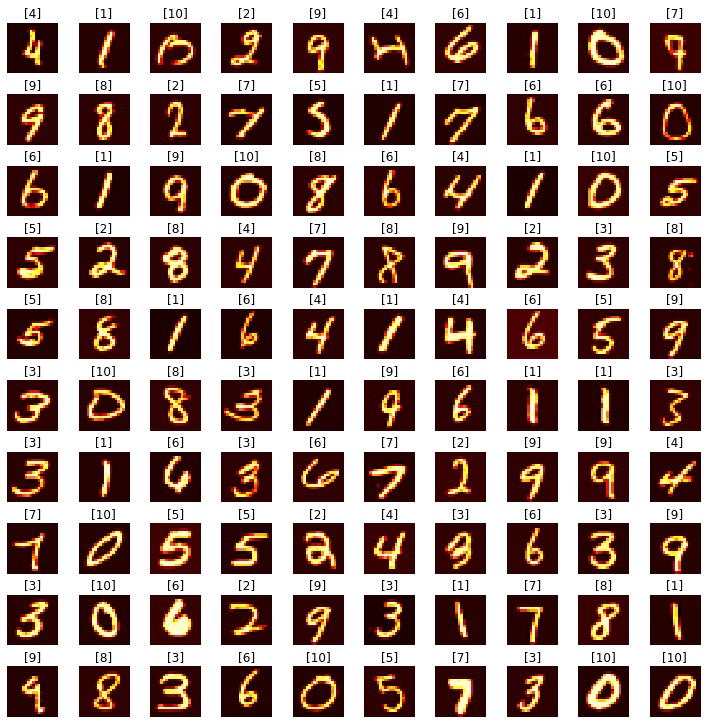

In [7]:
# Visualizing X
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        r_i = np.random.randint(0, X.shape[0]+1)
        ax[i, j].imshow(X[r_i].reshape(20, 20, order='F'), cmap='hot')
        ax[i, j].axis('off')
        ax[i, j].set_title(y[r_i])
fig.tight_layout(pad=0.5)

In [8]:
nn = NeuralNetwork(input_layer_size=400, hidden_layer_size=25, output_layer_size=10)

In [9]:
nn.fit(X, y, lambda_=1)

In [10]:
y_pred = nn.predict(X)

In [11]:
accuracy_score(y, y_pred)

0.9966

#### Example 2 (XOR)

In [12]:
X1 = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
])

y1 = np.array([
    [1],
    [2],
    [2],
    [1],
])

In [13]:
nn1 = NeuralNetwork(input_layer_size=2, hidden_layer_size=2, output_layer_size=2)

In [14]:
nn1.fit(X1, y1, lambda_=0)

In [15]:
nn1.predict(X1)

array([[1],
       [2],
       [2],
       [1]], dtype=int64)